<a href="https://colab.research.google.com/github/kundana12345/DataScience/blob/main/Kundana_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



In [4]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [5]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [ ]:
#normal
with pm.Model(coords=aa_coords) as cs_h_norm:
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', sigma=10)

    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa")
    σ = pm.HalfNormal('σ', sigma=10, dims="aa")

    y = pm.Normal('y', mu=μ[aa_idx], sigma=σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    idata_cs_h_norm = pm.sample(target_accept=0.95)


In [ ]:
with pm.Model(coords=aa_coords) as cs_h_t:

    μ_mu = pm.StudentT('μ_mu', nu=3, mu=0, sigma=10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=3, sigma=10)


    μ = pm.StudentT('μ', nu=3, mu=μ_mu, sigma=μ_sd, dims="aa")
    σ = pm.HalfStudentT('σ', nu=3, sigma=10, dims="aa")


    y = pm.StudentT('y', nu=5, mu=μ[aa_idx], sigma=σ[aa_idx],
                    observed=cs_data.diff_TminusE)

    idata_cs_h_t = pm.sample(target_accept=0.95)

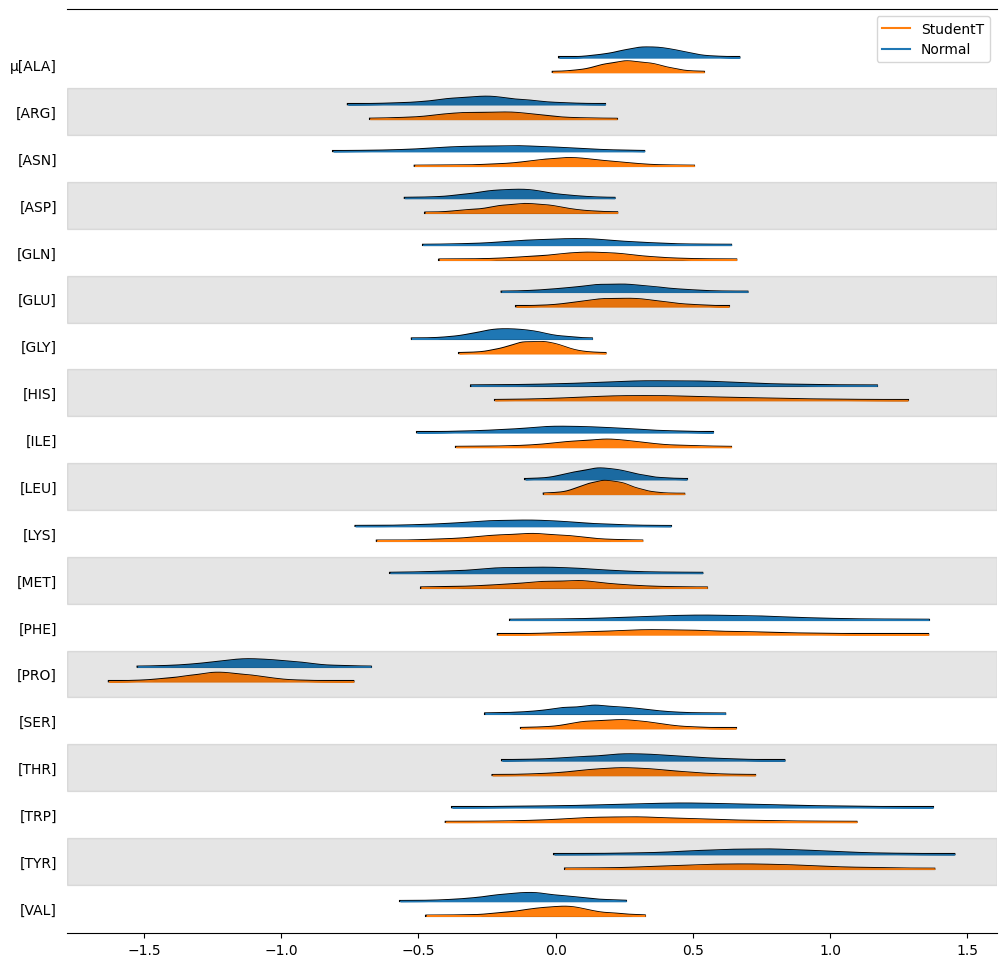

In [8]:
axes = az.plot_forest([idata_cs_h_norm, idata_cs_h_t],
                      kind="ridgeplot",
                      model_names=["Normal", "StudentT"],
                      var_names="μ",
                      combined=True,
                      figsize=(12, 12),
                      hdi_prob=0.997)
plt.show()

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
with cs_h_norm:
    ppc_norm = pm.sample_posterior_predictive(idata_cs_h_norm, extend_inferencedata=True)
with cs_h_t:
    ppc_t = pm.sample_posterior_predictive(idata_cs_h_t, extend_inferencedata=True)

In [10]:
idata_cs_h_norm.extend(ppc_norm)
idata_cs_h_t.extend(ppc_t)

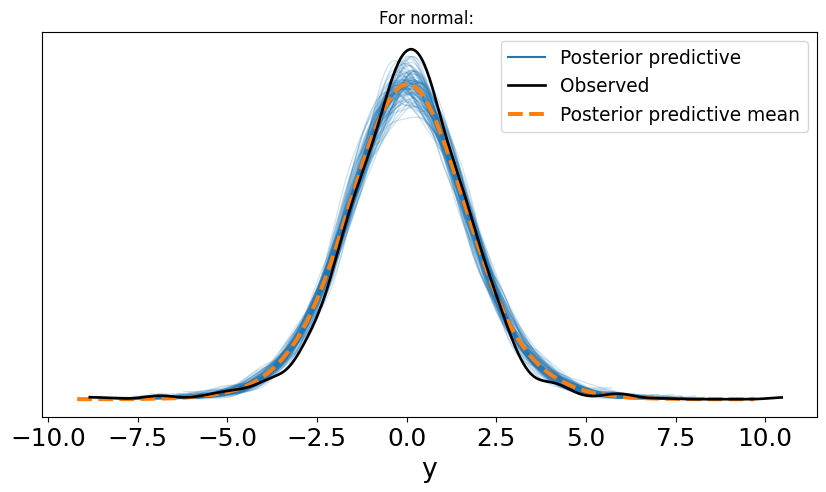

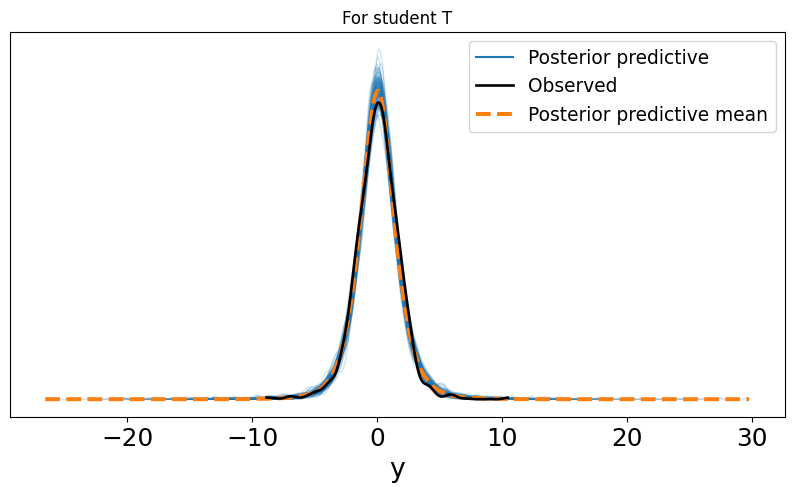

In [11]:
#from Gemini
az.plot_ppc(idata_cs_h_norm, figsize=(10, 5), num_pp_samples=100, group="posterior")
plt.title("For normal: ")
plt.show()

az.plot_ppc(idata_cs_h_t, figsize=(10, 5), num_pp_samples=100, group="posterior")
plt.title("For student T")
plt.show()

StudentT fits the data better. Especially at the top where y is a little less than 0.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [12]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})


#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}


In [ ]:
with pm.Model(coords=sccr_coords) as sccr_nh_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 0.1, nu = 30, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.004 1.002 1.0 1.001 ... 1.001 1.0 1.002
    μ_p      (pos) float64 32B 1.001 1.002 1.104 1.0
    ν_p      (pos) float64 32B 1.013 1.001 1.03 1.011

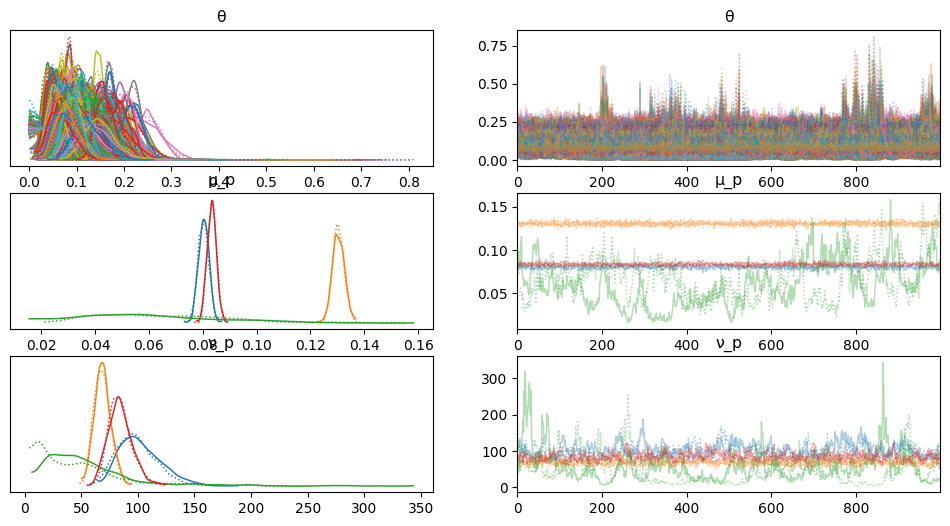

In [14]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

The green position looks different in each of these graphs (except the first row). In the bottom right  one, the green posistio of the non-hierarchical model is more varied than the green position for the hierarchical model.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

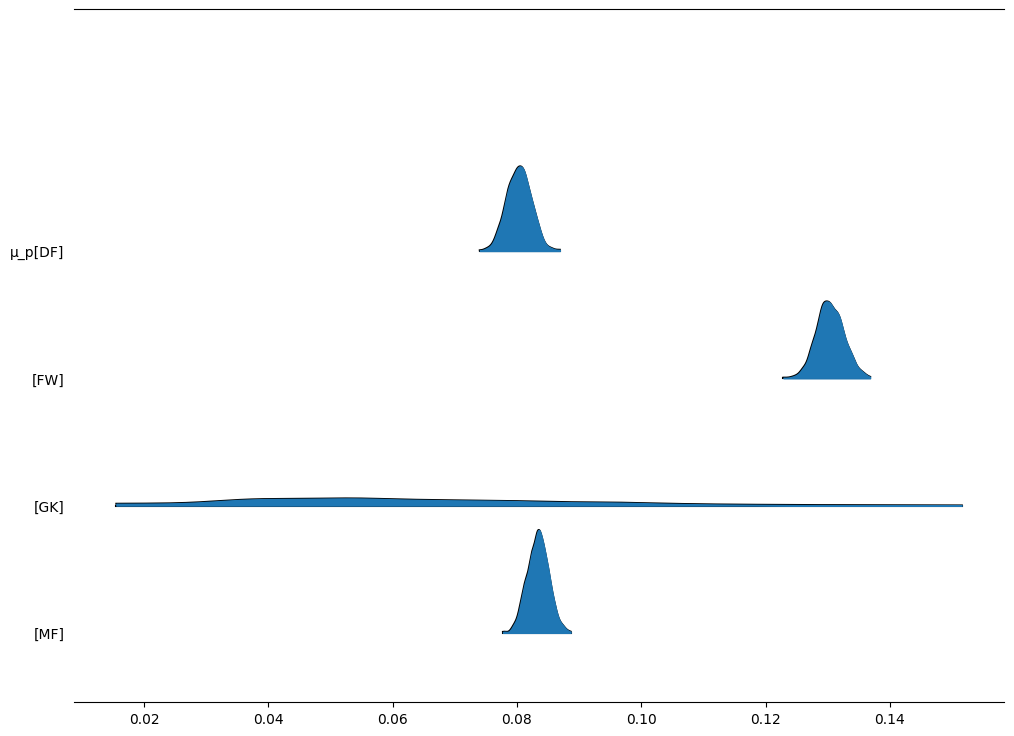

In [16]:
az.plot_forest(idata_sccr, kind="ridgeplot", var_names=['μ_p'], combined=True, figsize=(12, 9), hdi_prob=0.998)

The posteriors of the non hierarchical model are centered in the same place as the hierarchical model. GK has a higher range, it goes past 0.14.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [17]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
#from Gemini
sccr_data_new = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data_new = sccr_data_new.query('position != "GK"')
sccr_data_new['position'] = sccr_data_new['position'].astype('category')

pos_idx_new = sccr_data_new.position.cat.codes.values
pos_codes_new = sccr_data_new.position.cat.categories
sccr_coords_new = {"pos": pos_codes_new}

In [ ]:
with pm.Model(coords = sccr_coords_new) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_h_sccr = pm.sample(target_accept = 0.95)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.002 0.9995 1.002 ... 1.0 0.9999 1.002
    μ        float64 8B 1.003
    μ_p      (pos) float64 32B 1.003 1.001 1.05 1.003
    ν        float64 8B 1.003
    ν_p      (pos) float64 32B 1.019 1.001 1.086 1.008

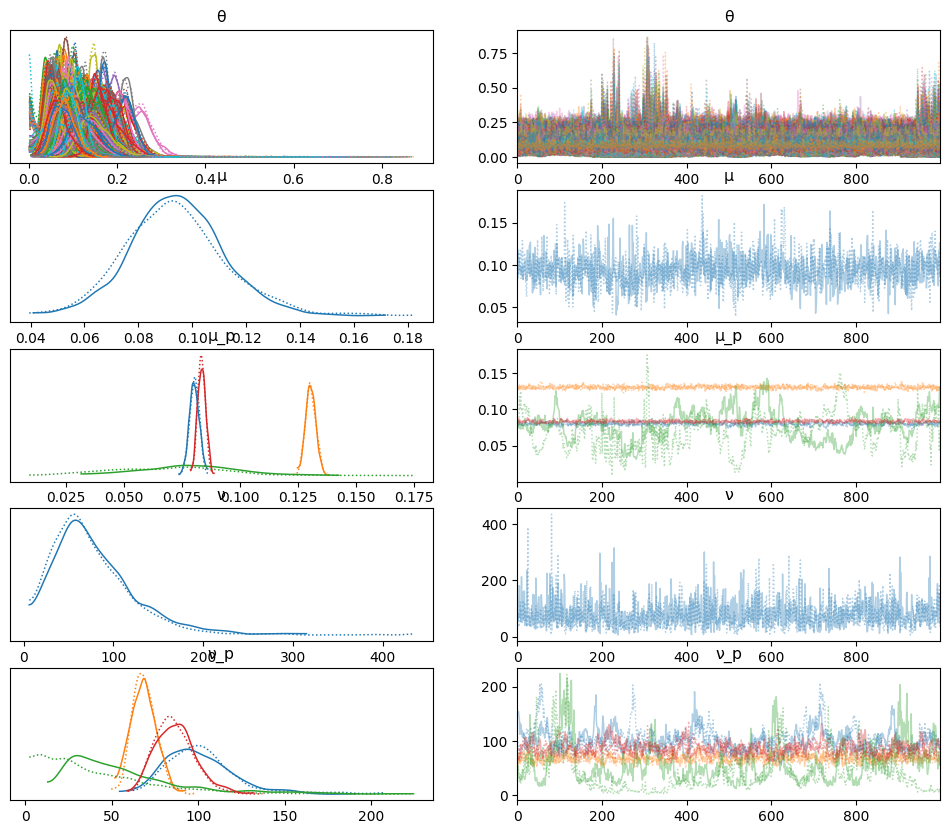

In [19]:
az.plot_trace(idata_h_sccr)
az.rhat(idata_h_sccr)



*   The model without GKs were easier for pymc to handle because it took less time.
*   When dropping GKs we lose precisions.

